In [1]:
import pandas as pd

import numpy as np
np.random.seed(0)

from IPython.display import display
import ipywidgets as widgets

import xgboost as xgb
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_val_score, cross_val_predict, learning_curve
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, f1_score, auc, accuracy_score, precision_recall_curve, recall_score, roc_auc_score, classification_report
from scikitplot.estimators import plot_learning_curve

import re
import sys

import scikitplot as skplt

import brewer2mpl
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

%matplotlib inline

In [2]:
df_new = pd.read_csv('../ML/df_new.csv')

In [3]:
df_new['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [4]:
# Undersampling - randomowa selekcja próbek Non-Fraud do trenowania modelu tak, aby spełnić stosunek próbek 1:4 Fraud:Non-Fraud.

In [5]:
def select_sample(df, class_name, number_of_sample):
    
    select = df[df['Class'] == class_name]
    selected_sample = select.sample(n = number_of_sample, replace = False)
    return selected_sample

In [6]:
non_fraud = select_sample(df_new, 0, 1968)

In [7]:
fraud = select_sample(df_new, 1, 492)

In [8]:
selected_sample = pd.concat([fraud, non_fraud])

In [9]:
print(selected_sample['Class'].value_counts()/len(selected_sample))

0    0.8
1    0.2
Name: Class, dtype: float64


In [10]:
# Funkcja do wyboru zmiennych do modelu.

In [11]:
def get_feats(df):
    feats = df.select_dtypes(include=[np.int, np.int8, np.int16, np.int32, np.float, np.float32]).columns
    black_list = ['Class', 'Amount']
    return [x for x in feats if x not in black_list]

In [12]:
# Funkcja do zdefiniowania zbiorów X, y.

In [13]:
def get_X(df, feat_fn=get_feats):
    return df[feat_fn(df)].values

def get_y(df, target_var='Class'):
    return df[target_var].values

In [14]:
# Funkcja do trenowania i testowania modeli.
# Zwraca główne metryki sukcesu tj, Precission/Recall AUC, Accuracy, ROC AUC, Gini.

In [15]:
def run_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = cross_val_predict(model, X_test, y_test, cv=5)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pre_rec_auc = auc(recall, precision)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    gini = 2*roc_auc - 1
    
    return print("pre_rec_auc = ", np.round(pre_rec_auc, 2), "accuracy = ", np.round(accuracy, 2), "roc_auc = ", np.round(roc_auc, 2), "gini = ", np.round(gini, 2))

In [16]:
# Wybór cech do modelu.

In [17]:
feats = get_feats(selected_sample)

In [18]:
X, y = get_X(selected_sample), get_y(selected_sample)

In [19]:
# Trenowanie i testowanie modelu.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [21]:
# Paramery dla modelu DecisionTreeClassifier

dt_params = {
    'max_depth': 5,
    'random_state': 0,
}

model = DecisionTreeClassifier(**dt_params)

In [22]:
run_model(model, X_train, X_test, y_train, y_test)

pre_rec_auc =  0.87 accuracy =  0.94 roc_auc =  0.91 gini =  0.81


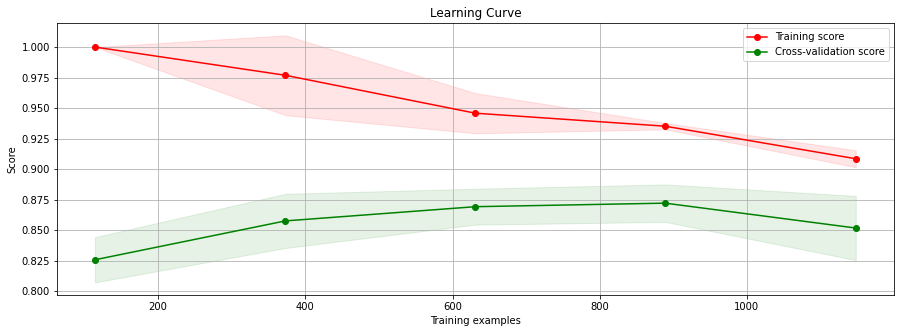

In [23]:
skplt.estimators.plot_learning_curve(model, X_train, y_train, figsize=(15, 5), cv=3, scoring='recall');

In [24]:
# Paramery dla modelu RandomForestClassifier

rf_params = {
    'max_depth': 5,
    'n_estimators': 100,
    'random_state': 0,
    'n_jobs': 4,
}

model = RandomForestClassifier(**rf_params)

In [25]:
run_model(model, X_train, X_test, y_train, y_test)

pre_rec_auc =  0.93 accuracy =  0.97 roc_auc =  0.92 gini =  0.83


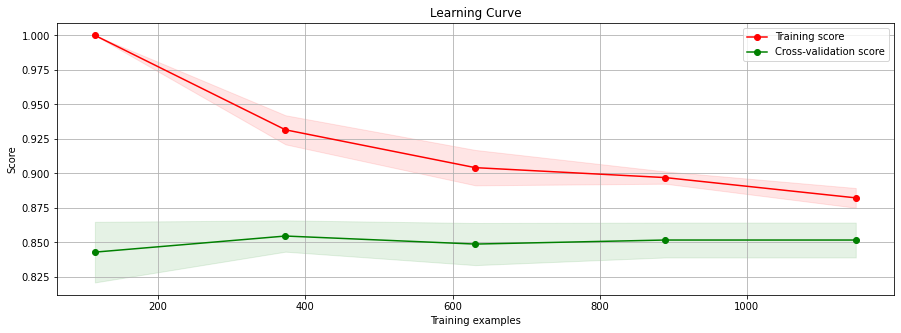

In [26]:
skplt.estimators.plot_learning_curve(model, X_train, y_train, figsize=(15, 5), cv=3, scoring='recall');

In [27]:
# Paramery dla modelu CatBoostClassifier

ctb_params = {
    'max_depth': 10,
    'n_estimators': 50,
    'random_state': 0,
    'verbose': False,
}

model = CatBoostClassifier(**ctb_params)

In [28]:
run_model(model, X_train, X_test, y_train, y_test)

pre_rec_auc =  0.92 accuracy =  0.96 roc_auc =  0.91 gini =  0.82


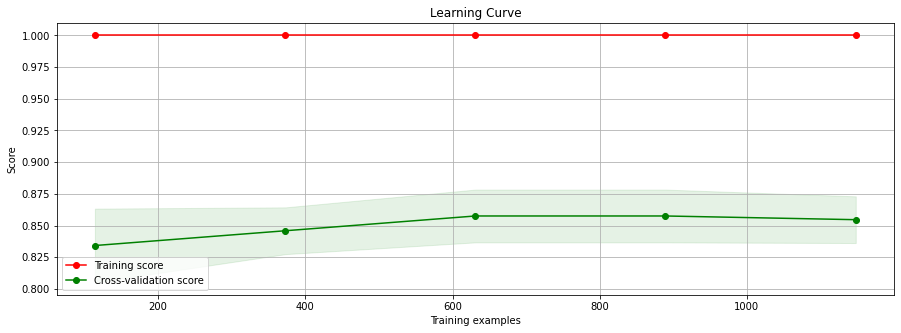

In [29]:
skplt.estimators.plot_learning_curve(model, X_train, y_train, figsize=(15, 5), cv=3, scoring='recall');

In [30]:
# Paramery dla modelu LGBMClassifier

lgbm_params = {
    'n_estimators': 50,
    'random_state': 0,
}

model = LGBMClassifier(**lgbm_params)

In [31]:
run_model(model, X_train, X_test, y_train, y_test)

pre_rec_auc =  0.92 accuracy =  0.96 roc_auc =  0.91 gini =  0.83


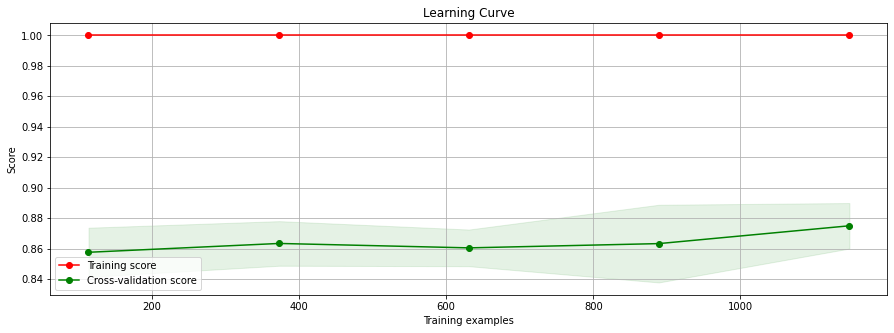

In [32]:
skplt.estimators.plot_learning_curve(model, X_train, y_train, figsize=(15, 5), cv=3, scoring='recall');

In [33]:
# Paramery dla modelu XGBClassifier

xgb_params = {
    'max_depth': 10,
    'n_estimators': 50,
    'learning_rate': 0.3,
    'random_state': 0,
    'subsample': 0.9,
    'colsample_bytree': 0.5,
}

model = xgb.XGBClassifier(**xgb_params)

In [34]:
run_model(model, X_train, X_test, y_train, y_test)

pre_rec_auc =  0.93 accuracy =  0.97 roc_auc =  0.92 gini =  0.84


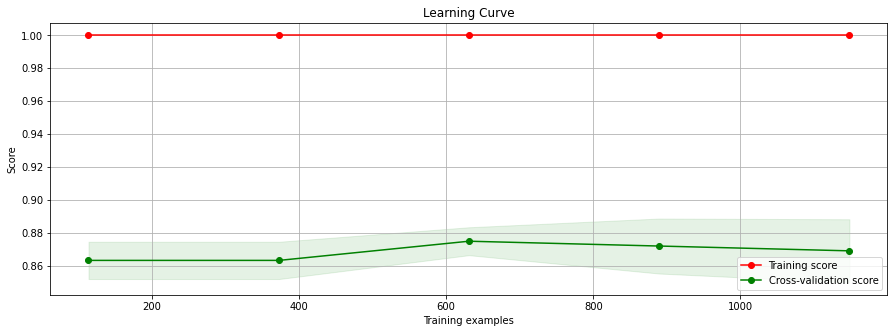

In [35]:
skplt.estimators.plot_learning_curve(model, X_train, y_train, figsize=(15, 5), cv=3, scoring='recall');

In [36]:
model.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.5, learning_rate=0.3, max_depth=10,
              n_estimators=50, subsample=0.9)

In [37]:
y_pred = cross_val_predict(model, X_test, y_test, cv=5)

In [38]:
labels = ['Non Fraud', 'Fraud']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

   Non Fraud       0.96      1.00      0.98       590
       Fraud       0.98      0.84      0.91       148

    accuracy                           0.97       738
   macro avg       0.97      0.92      0.94       738
weighted avg       0.97      0.97      0.97       738

